## RSI (Relative Strength Index, 상대강도지수)

#### 1) 개념

- 대표적인 모멘텀 지표 중 하나로, 주가의 평균 상승폭과 하락폭을 비교하여 가격의 상승 압력과 하락 압력 간의 상대적인 강도를 나타내는 기술적 지표
- 현재의 시장 상황이 과매수 상태인지, 아니면 과매도 상태인지 판단하기 위해 고안되었으며, 보통 RSI 70 이상을 과매수 상태로, RSI 30 이하를 과매도 상태로 판단

#### 2) 산출법

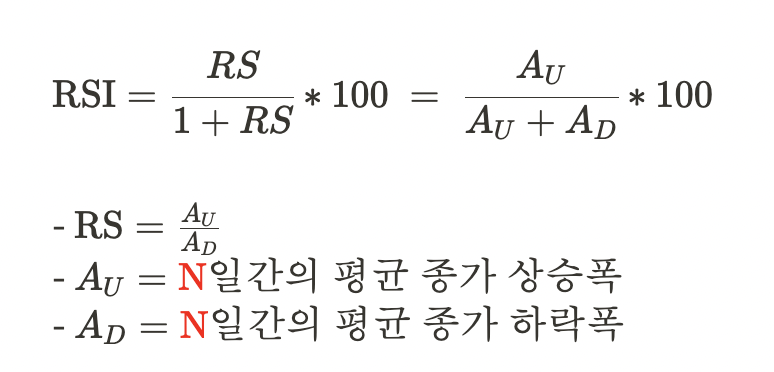
  
- 14일 동안 계속 상승만 하는 경우 AD 값은 0이 되고 이경우 RSI는 100이 된다. 반대로 14일 동안 계속 하락한 경우 AU는 0이 되고 RSI도 0이 된다.

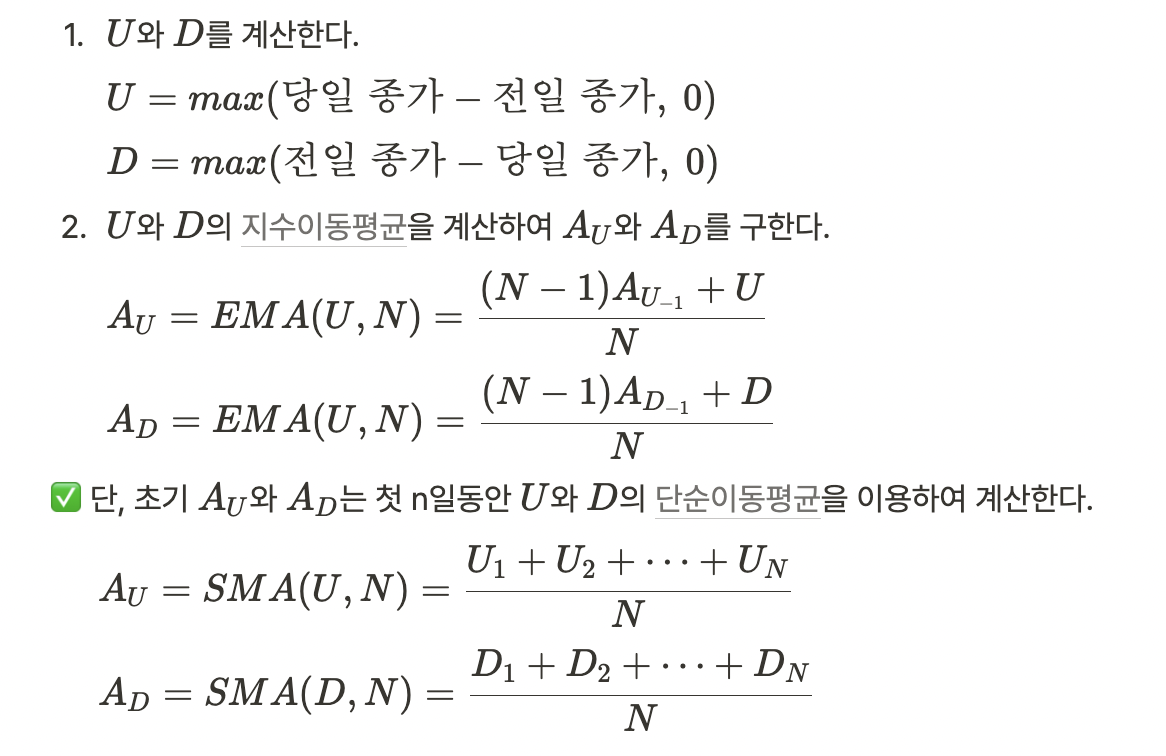

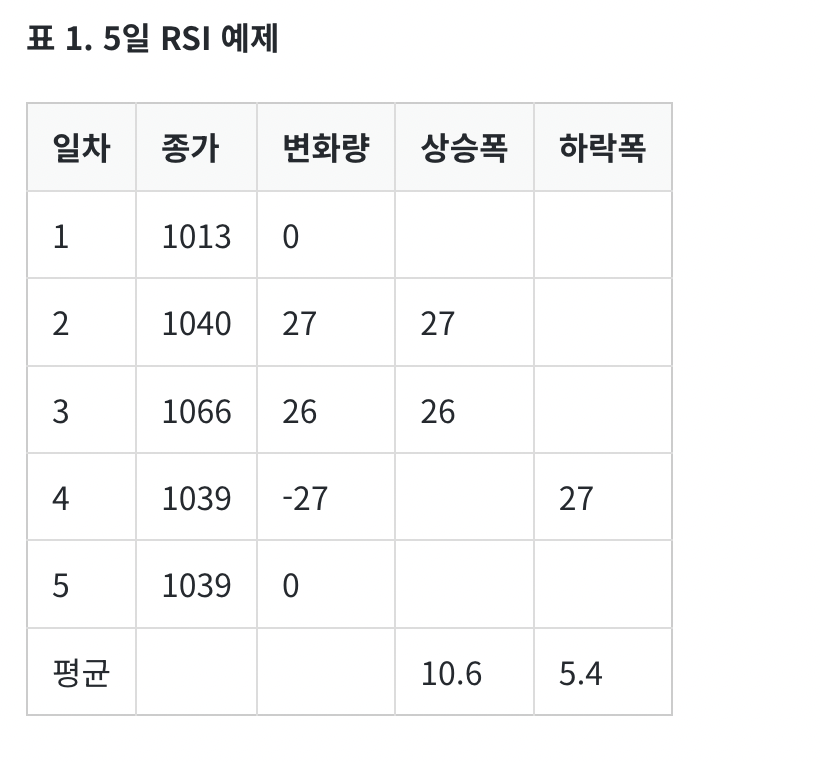

- RSI는 보통 WMA를 사용한다고 함 

In [71]:
import FinanceDataReader as fdr
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np

In [55]:
today = datetime.today().strftime('%Y-%m-%d')

df = fdr.DataReader("005930", start="2022-1-1", end=today)

In [56]:
df['변화량'] = df['Close'] - df['Close'].shift(1)
df['상승폭'] = np.where(df['변화량'] > 0, df['변화량'], 0)
df['하락폭'] = np.where(df['변화량'] < 0, df['변화량'].abs(), 0)

In [59]:
# welles moving average

# N(14)일 간의 평균 종가 상승폭
df['AU'] = df['상승폭'].ewm(alpha=1/14, min_periods=14).mean()

# N(14)일 간의 평균 종가 하락폭
df['AD'] = df['하락폭'].ewm(alpha=1/14, min_periods=14).mean()

In [61]:
#df['RS'] = df['AU'] / df['AD']
#df['RSI'] = 100 - (100 / (1 + df['RS']))

df['RSI'] = df['AU'] / (df['AU'] + df['AD']) * 100
df[['RSI']].tail(n=10)

,RSI
Date,
2023-12-28,78.393348
2024-01-02,80.903817
2024-01-03,62.437569
2024-01-04,60.162438
2024-01-05,60.162438
2024-01-08,59.533466
2024-01-09,49.501596
2024-01-10,44.559963
2024-01-11,42.883502


## 분석

#### 1) 해석

- RSI 값을 통해 상승 모멘텀과 하락 모멘텀의 강도를 확인할 수 있다.
    - RSI 지표는 해당 기간 동안 상승, 하락 변화량 변화량의 비율을 나타낸다. 일정 기간 동안 주가의 상승폭이 하락폭보다 큰 경우, 즉 상승 모멘텀이 강한 경우 RSI 값이 높아지며, 반대의 경우 RSI 값이 낮아진다.

#### 2) 과매도/과매수 
- RSI가 70 이상이면 과매수, 30 이하면 과매도 국면으로 판단할 수 있다.

In [62]:
def over_rsi(x):
    if x >= 70:
        return "과매수"
    elif x <= 30:
        return "과매도"
    else:
        return "정상"

In [63]:
df['RSI 국면'] = df['RSI'].apply(lambda x : over_rsi(x))
df = df.dropna()

In [64]:
df['RSI 국면'].value_counts()

RSI 국면
정상     451
과매도     25
과매수     11
Name: count, dtype: int64

- 기본적으로 주가가 일정 기간 이상 급격히 상승하면 과매수 구간으로 들어서게 되고, 조만간 하락할 것이라는 예측이 가능하다. 반대로, 일정 기간 이상 급격히 하락하면 과매도 구간에 진입하고 조만간 상승 할 것이라는 예측을 할 수 있다. 

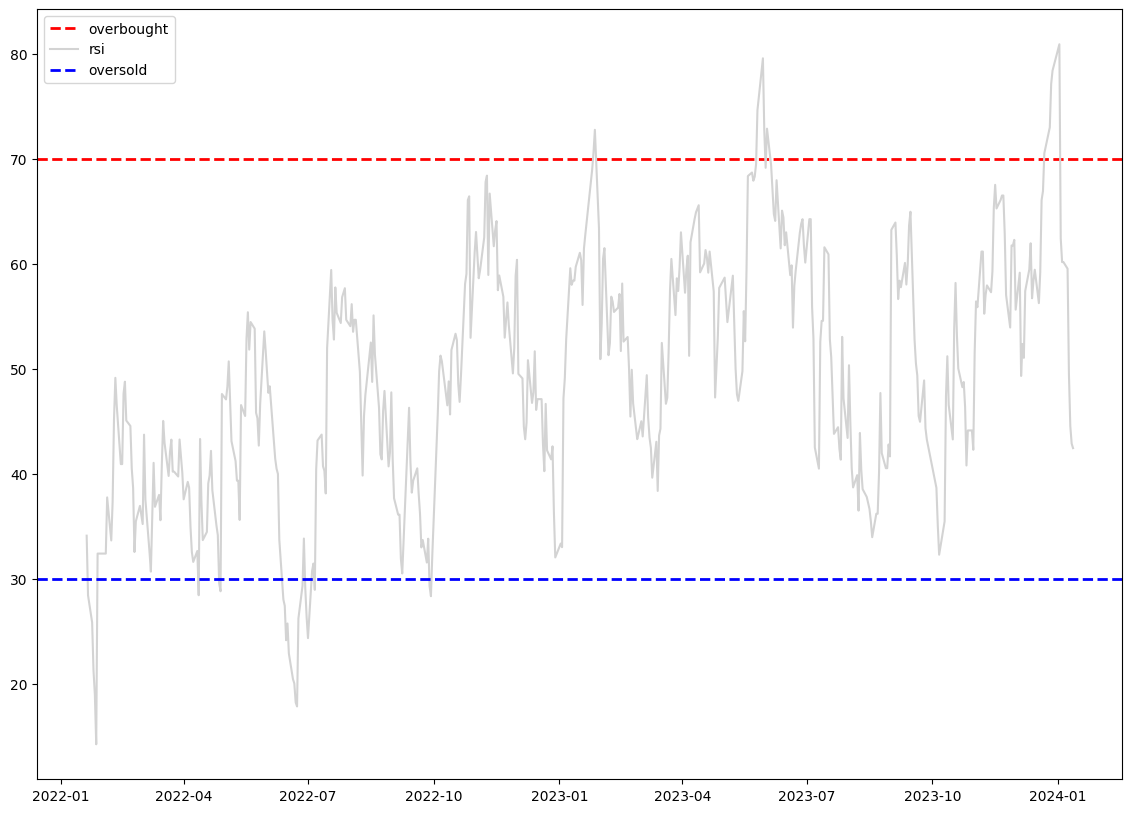

In [65]:
plt.figure(figsize=(14, 10))
plt.axhline(70, 0, 1, color='red', label='overbought',linestyle='--', linewidth=2)
plt.plot(df.index, df["RSI"], label='rsi', color='lightgray')
plt.axhline(30, 0, 1, color='blue', label='oversold',linestyle='--', linewidth=2)

plt.legend()
plt.show()

#### 3) 한계
- 천장과 바닥을 찾기에 용이하며, 추세가 강한 시장에서는 과열권에 머무를 수 있다.
- 하지만, 가격이 소폭의 등락만을 거듭하며 횡보하는 시장에서는 RSI가 50을 중심으로 소폭의 등락만을 거듭하게 되므로 투자 지표로 활용하는데 무리가 있음 

#### 4) 전략

(1) 과매도 / 과매수 매매전략

- 과매수 구간에서 매도하고 과매도 구간에서 매수하는 것이 일반적이다.
- 하지만 이 경우 대부분의 오실레이터형 지표와 마찬가지로 추세장에서는 과매수, 과매도 구간에 오래 머물며 추세가 연장되는 경우가 많아 이익을 내기 힘들다는 단점이 있다.

보완하기 위해 아래와 같은 전략을 사용   
  
- 과매수 구간에 머물던 RSI가 상단선을 하향 돌파 시(과매수가 해소될 때) 매도

- 과매도 구간에 머물던 RSI가 하단선을 상향 돌파 시(과매도가 해소될 때) 매수

/tmp/ipykernel_541/2300210186.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['RSI 국면'][i] == "정상":
/tmp/ipykernel_541/2300210186.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['RSI 국면'][i-1] == "과매수":
/tmp/ipykernel_541/2300210186.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['RSI 국면'][i-1] == "과매도":


=== 매도 포인트 ===
[('2023-01-30', '매도'), ('2023-06-01', '매도'), ('2023-06-05', '매도'), ('2024-01-03', '매도')]

=== 매수 포인트 ===
[('2022-01-28', '매수'), ('2022-04-13', '매수'), ('2022-04-29', '매수'), ('2022-06-28', '매수'), ('2022-07-04', '매수'), ('2022-07-07', '매수'), ('2022-09-30', '매수')]


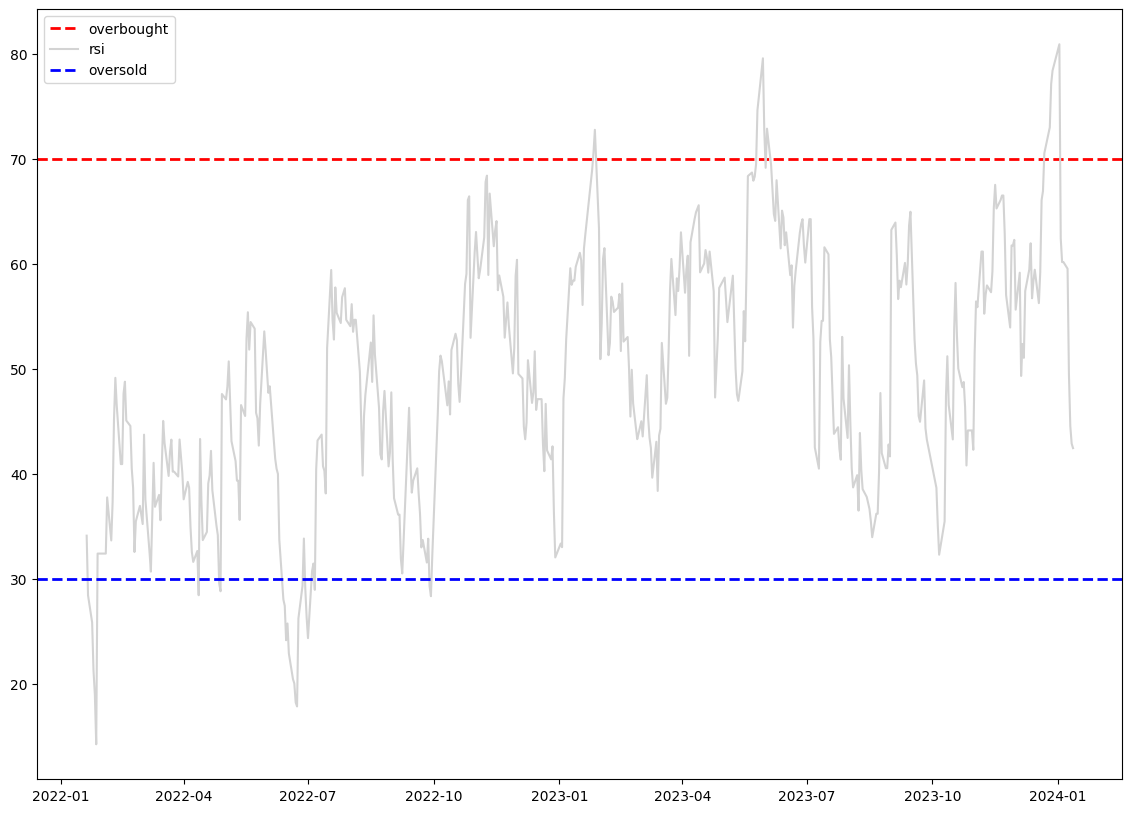

In [66]:

buy_points = []
sell_points = []

for i in range(1, len(df)):
    if df['RSI 국면'][i] == "정상":
        if df['RSI 국면'][i-1] == "과매수":
            sell_points.append((df.index[i].strftime("%Y-%m-%d"), "매도"))
        elif df['RSI 국면'][i-1] == "과매도":
            buy_points.append((df.index[i].strftime("%Y-%m-%d"), "매수"))

print("=== 매도 포인트 ===")
print(sell_points)
print()
print("=== 매수 포인트 ===")
print(buy_points)

plt.figure(figsize=(14, 10))
plt.axhline(70, 0, 1, color='red', label='overbought',linestyle='--', linewidth=2)
plt.plot(df.index, df["RSI"], label='rsi', color='lightgray')
plt.axhline(30, 0, 1, color='blue', label='oversold',linestyle='--', linewidth=2)

plt.legend()
plt.show()

#### 정리

In [72]:
# n = 기간 
def rsi_analysis(code, start_date="2018", n=14):

    today = datetime.today().strftime('%Y-%m-%d')
    
    df = fdr.DataReader(code, start=start_date, end=today)[["Close"]]

    
    df['변화량'] = df['Close'] - df['Close'].shift(1)
    df['상승폭'] = np.where(df['변화량'] > 0, df['변화량'], 0)
    df['하락폭'] = np.where(df['변화량'] < 0, df['변화량'].abs(), 0)
    
    # welles moving average

    # N(14)일 간의 평균 종가 상승폭
    df['AU'] = df['상승폭'].ewm(alpha=1/n, min_periods=n).mean()

    # N(14)일 간의 평균 종가 하락폭
    df['AD'] = df['하락폭'].ewm(alpha=1/n, min_periods=n).mean()
    
    
    df['RSI'] = df['AU'] / (df['AU'] + df['AD']) * 100

    df['RSI 국면'] = df['RSI'].apply(lambda x : over_rsi(x))
    df = df.dropna()
    
    
    
    buy_points = []
    sell_points = []

    for i in range(1, len(df)):
        if df['RSI 국면'][i] == "정상":
            if df['RSI 국면'][i-1] == "과매수":
                sell_points.append((df.index[i].strftime("%Y-%m-%d"), "매도"))
            elif df['RSI 국면'][i-1] == "과매도":
                buy_points.append((df.index[i].strftime("%Y-%m-%d"), "매수"))


    
    plt.figure(figsize=(14, 10))
    plt.axhline(70, 0, 1, color='red', label='overbought',linestyle='--', linewidth=2)
    plt.plot(df.index, df["RSI"], label='rsi', color='lightgray')
    plt.axhline(30, 0, 1, color='blue', label='oversold',linestyle='--', linewidth=2)

    plt.legend()
    plt.show()
    
    return buy_points, sell_points

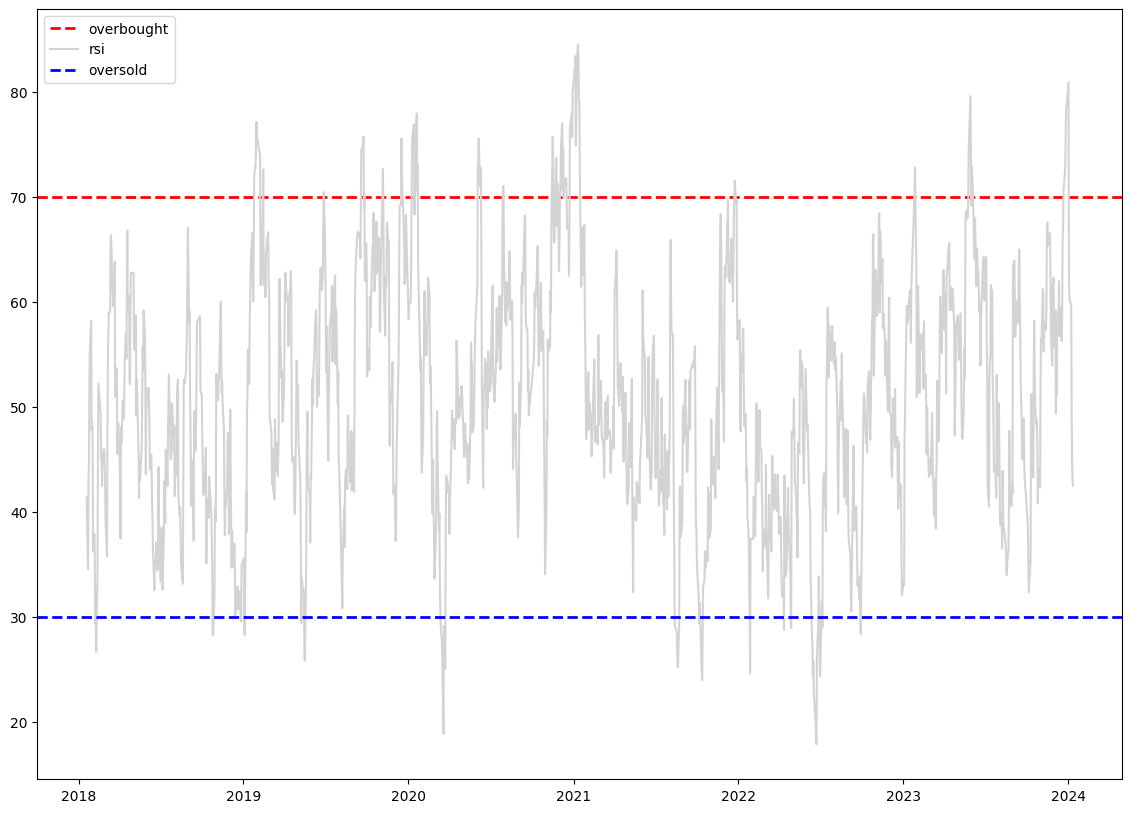

In [73]:
buy_points, sell_points = rsi_analysis("005930", n=14)

In [75]:
# 매수 포인트 
buy_points

[('2018-02-08', '매수'),
 ('2018-02-12', '매수'),
 ('2018-10-29', '매수'),
 ('2018-12-28', '매수'),
 ('2019-01-07', '매수'),
 ('2019-05-10', '매수'),
 ('2019-05-20', '매수'),
 ('2020-03-24', '매수'),
 ('2021-08-24', '매수'),
 ('2021-10-07', '매수'),
 ('2021-10-15', '매수'),
 ('2022-01-28', '매수'),
 ('2022-04-13', '매수'),
 ('2022-04-29', '매수'),
 ('2022-06-28', '매수'),
 ('2022-07-04', '매수'),
 ('2022-07-07', '매수'),
 ('2022-09-30', '매수')]

In [76]:
# 매도 포인트 
sell_points

[('2019-02-08', '매도'),
 ('2019-02-15', '매도'),
 ('2019-07-01', '매도'),
 ('2019-09-25', '매도'),
 ('2019-09-27', '매도'),
 ('2019-11-07', '매도'),
 ('2019-12-19', '매도'),
 ('2020-01-15', '매도'),
 ('2020-01-23', '매도'),
 ('2020-06-11', '매도'),
 ('2020-07-31', '매도'),
 ('2020-11-18', '매도'),
 ('2020-11-25', '매도'),
 ('2020-11-30', '매도'),
 ('2020-12-10', '매도'),
 ('2020-12-17', '매도'),
 ('2021-01-18', '매도'),
 ('2021-12-27', '매도'),
 ('2023-01-30', '매도'),
 ('2023-06-01', '매도'),
 ('2023-06-05', '매도'),
 ('2024-01-03', '매도')]